# CAPSTONE INVESTIGACIÓN OPERATIVA

In [40]:
#encender .venv
!.\.venv\Scripts\activate.bat

### Instalación de dependencias en el .venv

In [41]:
# Instala y actualiza los paquetes necesarios
%pip install --upgrade pip
%pip install numpy==2.2 pandas scikit-learn matplotlib joblib gurobipy gurobi-machinelearning pandas-datareader xgboost shap

# Verifica la versión de scikit-learn y Python
import sklearn, sys
print("Python version:", sys.version)
print("scikit-learn version:", sklearn.__version__)

# Importa y verifica pandas_datareader
import importlib
import pandas_datareader as pdr
print("pandas_datareader OK:", importlib.metadata.version("pandas-datareader"))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
scikit-learn version: 1.7.1
pandas_datareader OK: 0.10.0


### Importamos Librerias necesarias

In [42]:
# ============ Config & IO ============
import re
import time
#importamos numpy version 2.2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # muestra todas las columnas

# ============ Scikit-learn ============
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
# ===== IMPORTS extra =====
from sklearn.base import clone           # por si no lo tenías
from xgboost import XGBRegressor         # pip install xgboost


# ============ Gurobi / MIP ============
import gurobipy as gp
from gurobipy import GRB
from gurobi_ml import add_predictor_constr

# ============ Datos externos (opcional) ============
from pandas_datareader.data import DataReader  # si usas FRED/CPI
from sklearn.base import clone

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepocesamiento de la base de datos "AmesHousing"

In [43]:
FILE = "ames_dum.csv"
df = pd.read_csv(FILE)
df.head()


,Lot_Frontage,Lot_Area,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Garage_Finish,Garage_Cars,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Sale_Price,Longitude,Latitude,Sale_Price_Log,MS_SubClass_One_Story_1945_and_Older,MS_SubClass_One_Story_with_Finished_Attic_All_Ages,MS_SubClass_One_and_Half_Story_Unfinished_All_Ages,MS_SubClass_One_and_Half_Story_Finished_All_Ages,MS_SubClass_Two_Story_1946_and_Newer,MS_SubClass_Two_Story_1945_and_Older,MS_SubClass_Two_and_Half_Story_All_Ages,MS_SubClass_Split_or_Multilevel,MS_SubClass_Split_Foyer,MS_SubClass_Duplex_All_Styles_and_Ages,MS_SubClass_One_Story_PUD_1946_and_Newer,MS_SubClass_One_and_Half_Story_PUD_All_Ages,MS_SubClass_Two_Story_PUD_1946_and_Newer,MS_SubClass_PUD_Multilevel_Split_Level_Foyer,MS_SubClass_Two_Family_conversion_All_Styles_and_Ages,MS_Zoning_Residential_High_Density,MS_Zoning_Residential_Low_Density,MS_Zoning_Residential_Medium_Density,MS_Zoning_A_agr,MS_Zoning_C_all,MS_Zoning_I_all,Lot_Shape_Slightly_Irregular,Lot_Shape_Moderately_Irregular,Lot_Shape_Irregular,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl,Lot_Config_CulDSac,Lot_Config_FR2,Lot_Config_FR3,Lot_Config_Inside,Neighborhood_College_Creek,Neighborhood_Old_Town,Neighborhood_Edwards,Neighborhood_Somerset,Neighborhood_Northridge_Heights,Neighborhood_Gilbert,Neighborhood_Sawyer,Neighborhood_Northwest_Ames,Neighborhood_Sawyer_West,Neighborhood_Mitchell,Neighborhood_Brookside,Neighborhood_Crawford,Neighborhood_Iowa_DOT_and_Rail_Road,Neighborhood_Timberland,Neighborhood_Northridge,Neighborhood_Stone_Brook,Neighborhood_South_and_West_of_Iowa_State_University,Neighborhood_Clear_Creek,Neighborhood_Meadow_Village,Neighborhood_Briardale,Neighborhood_Bloomington_Heights,Neighborhood_Veenker,Neighborhood_Northpark_Villa,Neighborhood_Blueste,Neighborhood_Greens,Neighborhood_Green_Hills,Neighborhood_Landmark,Neighborhood_Hayden_Lake,Condition_1_Feedr,Condition_1_Norm,Condition_1_PosA,Condition_1_PosN,Condition_1_RRAe,Condition_1_RRAn,Condition_1_RRNe,Condition_1_RRNn,Bldg_Type_TwoFmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,House_Style_One_and_Half_Unf,House_Style_One_Story,House_Style_SFoyer,House_Style_SLvl,House_Style_Two_and_Half_Fin,House_Style_Two_and_Half_Unf,House_Style_Two_Story,Roof_Style_Gable,Roof_Style_Gambrel,Roof_Style_Hip,Roof_Style_Mansard,Roof_Style_Shed,Roof_Matl_CompShg,Roof_Matl_Membran,Roof_Matl_Metal,Roof_Matl_Roll,Roof_Matl_Tar&Grv,Roof_Matl_WdShake,Roof_Matl_WdShngl,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_BrkFace,Exterior_1st_CBlock,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_ImStucc,Exterior_1st_MetalSd,Exterior_1st_Plywood,Exterior_1st_PreCast,Exterior_1st_Stone,Exterior_1st_Stucco,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_WdShing,Exterior_2nd_AsphShn,Exterior_2nd_Brk Cmn,Exterior_2nd_BrkFace,Exterior_2nd_CBlock,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_ImStucc,Exterior_2nd_MetalSd,Exterior_2nd_Other,Exterior_2nd_Plywood,Exterior_2nd_PreCast,Exterior_2nd_Stone,Exterior_2nd_Stucco,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_Wd Shng,Mas_Vnr_Type_BrkFace,Mas_Vnr_Type_CBlock,Mas_Vnr_Type_None,Mas_Vnr_Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central_Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_CarPort,Garage_Type_Detchd,Garage_Type_More_Than_Two_Types,Garage_Type_No_Garage,Sale_Type

In [44]:
FILE = "ames_dum.csv"


def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # versiones viejas de sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))





y_real = df["Sale_Price_Log"].copy()
X = df.drop(columns=[
    "Sale_Price", "Sale_Price_Log",

    # Variables con baja o nula importancia en XGBoost (< 0.009)
    "Garage_Finish","TotRms_AbvGrd","Neighborhood_Crawford","BsmtFin_Type_1",
    "Year_Remod_Add","Overall_Cond","Half_Bath","Bsmt_Full_Bath","Lot_Area",
    "Sale_Type_New","Sale_Condition_Normal","Bsmt_Exposure","Heating_QC",
    "Neighborhood_Old_Town","Functional","Neighborhood_Iowa_DOT_and_Rail_Road",
    "Exter_Cond","Screen_Porch","Garage_Type_No_Garage","Open_Porch_SF",
    "Exterior_1st_BrkFace","Neighborhood_Somerset","Neighborhood_Edwards",
    "MS_Zoning_C_all","Sale_Condition_Partial","MS_SubClass_One_Story_PUD_1946_and_Newer",
    "Condition_1_Norm","Neighborhood_Brookside","Neighborhood_Clear_Creek",
    "House_Style_One_Story","Garage_Qual","MS_SubClass_One_and_Half_Story_Finished_All_Ages",
    "Condition_1_Feedr","Wood_Deck_SF","Mas_Vnr_Area","Land_Slope","Longitude",
    "Foundation_PConc","Bedroom_AbvGr","Exterior_2nd_VinylSd","BsmtFin_SF_1",
    "Heating_GasA","Roof_Matl_Tar&Grv","Neighborhood_Northwest_Ames","Lot_Config_FR2",
    "Latitude","Sale_Condition_Family","Foundation_CBlock","Exterior_1st_Wd Sdng",
    "Neighborhood_South_and_West_of_Iowa_State_University","Land_Contour_Lvl",
    "Bsmt_Unf_SF","Roof_Style_Hip","Sale_Type_WD","Neighborhood_Sawyer",
    "Exterior_2nd_CmentBd","House_Style_SLvl",

    # Variables irrelevantes (importancia ≈ 0)
    "Neighborhood_Sawyer_West","Kitchen_AbvGr","Exterior_1st_VinylSd","Mas_Vnr_Type_BrkFace",
    "MS_SubClass_Two_Story_1945_and_Older","Condition_1_PosN","Neighborhood_Northridge",
    "Exterior_2nd_Stucco","Exterior_2nd_MetalSd","Sale_Condition_Alloca","Enclosed_Porch",
    "Neighborhood_Mitchell","Mas_Vnr_Type_None","Bsmt_Cond","Land_Contour_Low",
    "Sale_Condition_AdjLand","Land_Contour_HLS","Lot_Frontage","Electrical_SBrkr",
    "Exterior_2nd_HdBoard","Pool_Area","Bldg_Type_TwoFmCon","Roof_Matl_CompShg",
    "Exterior_2nd_Plywood","MS_Zoning_Residential_High_Density","Exterior_1st_Plywood",
    "Condition_1_PosA","Lot_Shape_Slightly_Irregular","Condition_1_RRAe",
    "MS_SubClass_Two_and_Half_Story_All_Ages","Neighborhood_Stone_Brook","BsmtFin_SF_2",
    "Mas_Vnr_Type_Stone","Neighborhood_Green_Hills","Lot_Config_CulDSac",
    "MS_SubClass_Duplex_All_Styles_and_Ages","Garage_Type_CarPort","Heating_GasW",
    "Sale_Type_ConLD","Sale_Type_Oth","Roof_Style_Gable","Garage_Type_Basment",
    "House_Style_Two_Story","Lot_Config_Inside","BsmtFin_Type_2","Lot_Shape_Irregular",
    "Sale_Type_ConLw","Neighborhood_Gilbert","MS_SubClass_Two_Family_conversion_All_Styles_and_Ages",
    "Exterior_1st_Stucco","Low_Qual_Fin_SF","Exterior_2nd_Wd Sdng","Exterior_1st_MetalSd",
    "MS_SubClass_Split_Foyer","Roof_Style_Gambrel","Heating_Grav","Bsmt_Half_Bath",
    "Neighborhood_Timberland","Neighborhood_Northridge_Heights","Garage_Type_BuiltIn",
    "Exterior_1st_CemntBd","Neighborhood_Bloomington_Heights","MS_SubClass_Two_Story_PUD_1946_and_Newer",
    "Foundation_Stone","Neighborhood_Meadow_Village","Heating_Wall","House_Style_Two_and_Half_Unf",
    "Neighborhood_Veenker","Foundation_Slab","Exterior_2nd_BrkFace","Lot_Config_FR3",
    "Misc_Val","Three_season_porch","Electrical_FuseF","Neighborhood_College_Creek",
    "Lot_Shape_Moderately_Irregular","Exterior_1st_HdBoard","Bldg_Type_TwnhsE",
    "Exterior_2nd_Wd Shng","MS_SubClass_Split_or_Multilevel","Exterior_2nd_ImStucc",
    "Condition_1_RRNn","Exterior_1st_WdShing","House_Style_SFoyer","Roof_Matl_WdShake",
    "MS_Zoning_A_agr","MS_Zoning_I_all","MS_SubClass_PUD_Multilevel_Split_Level_Foyer",
    "MS_SubClass_One_and_Half_Story_Unfinished_All_Ages","MS_SubClass_One_Story_with_Finished_Attic_All_Ages",
    "MS_SubClass_One_and_Half_Story_PUD_All_Ages","Neighborhood_Hayden_Lake","Neighborhood_Greens",
    "Neighborhood_Blueste","Neighborhood_Northpark_Villa","Neighborhood_Briardale",
    "Neighborhood_Landmark","Bldg_Type_Twnhs","House_Style_Two_and_Half_Fin","Condition_1_RRAn",
    "Exterior_1st_ImStucc","Exterior_1st_CBlock","Exterior_1st_AsphShn","Exterior_1st_BrkComm",
    "Roof_Matl_WdShngl","Roof_Style_Shed","Roof_Matl_Roll","Roof_Matl_Metal","Roof_Style_Mansard",
    "Roof_Matl_Membran","Condition_1_RRNe","Bldg_Type_Duplex","House_Style_One_and_Half_Unf",
    "Exterior_1st_Stone","Exterior_2nd_AsphShn","Exterior_2nd_Brk Cmn","Mas_Vnr_Type_CBlock",
    "Exterior_2nd_Stone","Exterior_2nd_Other","Exterior_2nd_PreCast","Exterior_1st_PreCast",
    "Exterior_2nd_CBlock","Foundation_Wood","Heating_OthW","Electrical_Mix","Electrical_FuseP",
    "Electrical_Unknown","Sale_Type_Con","Sale_Type_CWD","Sale_Type_ConLI",
    "Garage_Type_More_Than_Two_Types","Sale_Type_VWD", "Overall_Quall"
]).copy()


feats = X.columns.tolist()
medians = X.median(numeric_only=True)
X   = X.fillna(medians).copy()     # <- sin NaN
# ====== 3) Modelos (Pipelines): Lineal y GBR ======
# ====== 3) Modelos (Pipelines): Lineal, GBR y XGBoost ======
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("est", LinearRegression())
    ]),
    "GBR": Pipeline([
        ("scaler", StandardScaler()),
        ("est", GradientBoostingRegressor(
            learning_rate=0.05, n_estimators=400, max_depth=3,
            subsample=0.9, random_state=42
        ))
    ]),
    "XGB": Pipeline([
        ("scaler", "passthrough"),   # árboles no necesitan escalado
        ("est", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=2,
            reg_lambda=5.0,
            n_jobs=-1,
            tree_method="hist",
            random_state=42
        ))
    ])
}


def cv_eval(estimator, X, y_log, folds=5, seed=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    y_true, y_pred = [], []
    for tr, te in kf.split(X):
        Xt, Xv = X.iloc[tr], X.iloc[te]
        yt, yv = y_log.iloc[tr], y_log.iloc[te]
        m = clone(estimator)
        m.fit(Xt, yt)
        pv = np.expm1(m.predict(Xv))  # de log a precio real
        y_true.append(np.expm1(yv)); y_pred.append(pv)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "RMSE": rmse_compat(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ====== 4) Evaluación y entrenamiento final ======
rows, fitted = [], {}
for name, est in models.items():
    metrics = cv_eval(est, X, y_real)
    rows.append({"model": name, **{k: round(v,3) for k,v in metrics.items()}})
    est.fit(X, y_real)          # entrena full para el “modelo final”
    fitted[name] = est

results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print(results)

best_name = results.iloc[0]["model"]
best_model = fitted[best_name]
print(f"\nGanador por RMSE (CV): {best_name}")

# ====== 5) Interpretabilidad básica para el informe ======
# ====== 5) Interpretabilidad básica para el informe ======
if best_name == "Linear":
    lr = best_model.named_steps["est"]
    coefs = pd.Series(lr.coef_.ravel(), index=feats).sort_values(key=np.abs, ascending=False)
    print("\nCoeficientes (ordenados por |coef|) — escala estandarizada:")
    print(coefs.to_string())
else:
    # Sirve tanto para GBR como para XGB
    tree_est = best_model.named_steps["est"]
    imps = pd.Series(tree_est.feature_importances_, index=feats).sort_values(ascending=False)
    print(f"\nImportancias de características ({best_name}):")
    print(imps.to_string())


# Para usar más tarde en Gurobi:
trained_feats = feats
trained_stats = pd.DataFrame({"q05": X.quantile(0.05), "median": X.median(), "q95": X.quantile(0.95)})
best_linear_model = fitted["Linear"]
best_gbr_model    = fitted["GBR"]



KeyError: "['Sale_Type_WD', 'Overall_Quall'] not found in axis"

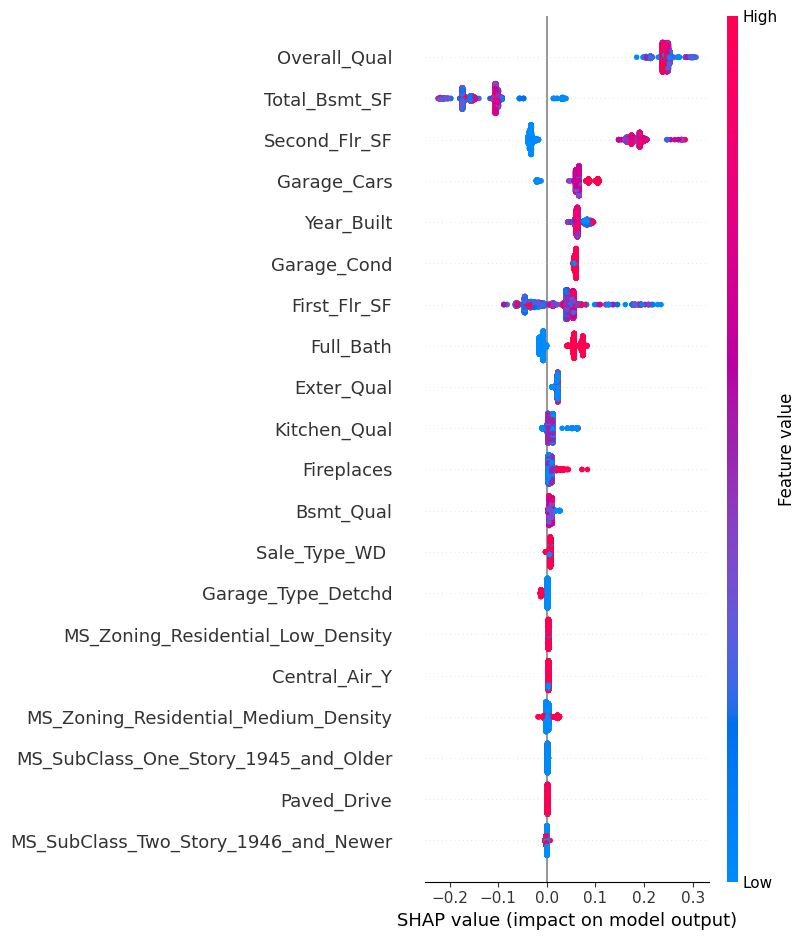

In [ ]:
#vemos shap
import shap
explainer = shap.Explainer(best_gbr_model.named_steps["est"])
shap_values = explainer(X)
shap.summary_plot(shap_values, X)  # resumen de todas las características

In [ ]:


for (index, fila), y in zip(df.iterrows(), y_real):
    print(y, fila.Sale_Price, fila.SalePrice * (CPI_TARGET / fila.CPI_sale), fila.Yr_Sold, fila.Mo_Sold, fila.CPI_sale)


AttributeError: 'Series' object has no attribute 'SalePrice'

### Parámetros del modelo

In [ ]:
# ----------------------------
# 2) Baseline, límites y costos (FIX)
# ----------------------------
# Requiere que ya existan:
# X, y_real, trained_feats, trained_stats (q05/median/q95), best_linear_model, best_gbr_model

ID_CASA = 987  # índice por fila (iloc)

# 1) Baseline: misma estructura (columnas) que se usó al entrenar
n = len(X)
idx = ID_CASA if 0 <= ID_CASA < n else 0  # fallback si se pasa de rango
baseline = X.iloc[idx].astype(float)

print("Caso base (features):")
print(baseline.to_string())

# 2) Elige el predictor (pipeline) que quieras evaluar como baseline
#    Puedes cambiar a best_linear_model si prefieres la lineal
PREDICTOR = best_gbr_model

# Predicción en log (nuestros modelos entrenan sobre y_log)
pred_log = float(PREDICTOR.predict(baseline.to_frame().T)[0])
precio_base_pred = float(np.expm1(pred_log))
print(f"\nPrecio base predicho: {precio_base_pred:,.0f}")

# Precio real de esa fila (en escala original; ya inflacionado si ajustaste antes)
precio_real = float(y_real.iloc[idx])
print(f"Precio real observado: {precio_real:,.0f}")

# 3) Cuantil 95% por feature (para cotas superiores)
q95 = trained_stats["q95"]  # viene de: trained_stats = DataFrame({q05, median, q95})

# 4) Costos por unidad (revisa unidades: p. ej., Gr_Liv_Area está en ft²)
default_costs = {
    "Gr_Liv_Area":     200,   # USD por ft²
    "Total_Bsmt_SF":    80,   # USD por ft²
    "Garage_Area":      60,   # USD por ft²
    "Garage_Cars":   17000,   # USD por puesto
    "Full_Bath":     25000,   # USD por baño
    "Fireplaces":      6000,  # USD por chimenea
    "Overall_Qual":   20000,  # USD por subir 1 punto (proxy)
    "KitchenQual_ord": 8000,  # USD por subir 1 nivel (TA→Gd→Ex) (ejemplo)
    "GarageFinish_ord":4000,  # USD por subir 1 nivel (Unf→RFn→Fin) (ejemplo)
}

# 5) "Room to grow" máximo (cuánto puedes mover vs baseline, si la norma/lote lo permite)
room = {
    "Gr_Liv_Area":     400.0,
    "Total_Bsmt_SF":   300.0,
    "Garage_Area":     250.0,
    "Garage_Cars":       1.0,   # sube a 2 si el lote lo permite
    "Full_Bath":         1.0,
    "Fireplaces":        1.0,
    "Overall_Qual":      1.0,
    "KitchenQual_ord":   1.0,
    "GarageFinish_ord":  1.0,
}

# 6) Construir cotas y costos por feature (solo para las usadas al entrenar)
bounds, costs = {}, {}
for f in trained_feats:
    base = float(baseline.get(f, X[f].median()))
    ub_by_room = base + room.get(f, 0.0)          # límite por “capacidad de cambio”
    ub_by_p95  = float(q95.get(f, base))          # límite por mercado (evita extrapolación)
    lb = base                                     # no bajamos de lo que ya tiene la casa base
    ub = max(lb, min(ub_by_room, ub_by_p95))      # asegura lb <= ub
    bounds[f] = (lb, ub)
    costs[f]  = float(default_costs.get(f, 0.0))

BUDGET = 200_000  # mismo orden de magnitud que tus costos (USD en este ejemplo)

print("\nLímites por feature (lb, ub):")
for f, (lb, ub) in bounds.items():
    if ub > lb:
        print(f"  {f:>16}: {lb:,.2f} → {ub:,.2f}")
    else:
        print(f"  {f:>16}: {lb:,.2f} (sin margen de aumento por p95/room)")

print("\nCostos unitarios usados:")
for f in trained_feats:
    if costs[f] > 0:
        print(f"  {f:>16}: {costs[f]:,.0f}")


Caso base (features):
Gr_Liv_Area         1567.0
Total_Bsmt_SF       1567.0
Garage_Area          714.0
Garage_Cars            2.0
Full_Bath              2.0
Fireplaces             2.0
Overall_Qual           6.0
KitchenQual_ord        4.0
GarageFinish_ord       2.0
Mo_Sold                5.0

Precio base predicho: 340,377
Precio real observado: 296,925

Límites por feature (lb, ub):
       Gr_Liv_Area: 1,567.00 → 1,967.00
     Total_Bsmt_SF: 1,567.00 → 1,776.00
       Garage_Area: 714.00 → 856.00
       Garage_Cars: 2.00 → 3.00
         Full_Bath: 2.00 (sin margen de aumento por p95/room)
        Fireplaces: 2.00 (sin margen de aumento por p95/room)
      Overall_Qual: 6.00 → 7.00
   KitchenQual_ord: 4.00 → 5.00
  GarageFinish_ord: 2.00 → 3.00
           Mo_Sold: 5.00 (sin margen de aumento por p95/room)

Costos unitarios usados:
       Gr_Liv_Area: 200
     Total_Bsmt_SF: 80
       Garage_Area: 60
       Garage_Cars: 17,000
         Full_Bath: 25,000
        Fireplaces: 6,000
      Ove

### Guroby

In [ ]:
# ---------- Parámetros ----------
MODEL_NAME     = "auto"          # "auto" | "Linear" | "GBR"
OBJECTIVE_MODE = "profit"        # "price" | "profit" | "roi"
ROI_MIN        = 0.10            # usado sólo si OBJECTIVE_MODE == "roi"
PWL_K          = 25              # segmentos para PWL (log1p -> price)

# ---------- Resolver el estimador (con nuestro flujo Linear/GBR) ----------
# Requiere: best_linear_model, best_gbr_model, (opcional) results con RMSE
available = {}
if 'best_linear_model' in globals(): available["Linear"] = best_linear_model
if 'best_gbr_model'    in globals(): available["GBR"]    = best_gbr_model
assert available, "No encuentro modelos entrenados (best_linear_model / best_gbr_model)."

if MODEL_NAME == "auto":
    if 'results' in globals():
        # elige el mejor entre los disponibles por RMSE
        ok = results[results["model"].isin(available.keys())].sort_values("RMSE")
        chosen = ok.iloc[0]["model"] if len(ok) else next(iter(available))
    else:
        # fallback: prioriza GBR si existe
        chosen = "GBR" if "GBR" in available else "Linear"
else:
    assert MODEL_NAME in available, f"'{MODEL_NAME}' no está disponible. Usa 'Linear' o 'GBR'."
    chosen = MODEL_NAME

predictor = available[chosen]



print(f"→ Usando modelo: {chosen}")

# ---------- Columnas esperadas ----------
assert 'trained_feats' in globals(), "Falta 'trained_feats' (columnas de entrenamiento)."
feat_names_model = list(trained_feats)

for need in ("baseline","bounds","costs","BUDGET"):
    assert need in globals(), f"Falta '{need}' en el entorno."

missing = [c for c in feat_names_model if c not in bounds or c not in costs or c not in baseline.index]
assert not missing, f"Faltan claves en bounds/baseline/costs para: {missing}"

# ---------- Modelo de optimización ----------
m = gp.Model(f"ames_renov_opt_{chosen}")
int_like = {"Garage_Cars","Full_Bath","Fireplaces","Overall_Qual","KitchenQual_ord","GarageFinish_ord"}
x = {}
for c in feat_names_model:
    lb, ub = bounds[c]
    if c in int_like:
        lb_i, ub_i = int(np.floor(lb)), int(np.ceil(ub))
        if ub_i < lb_i: ub_i = lb_i
        x[c] = m.addVar(lb=lb_i, ub=ub_i, vtype=GRB.INTEGER,   name=c)
    else:
        x[c] = m.addVar(lb=float(lb), ub=float(ub), vtype=GRB.CONTINUOUS, name=c)

# Presupuesto (sólo mejoras; ya aseguramos lb = baseline en bounds)
cost_expr = gp.quicksum(costs[c] * (x[c] - float(baseline[c])) for c in feat_names_model)
m.addConstr(cost_expr <= float(BUDGET), name="Budget")

# (Opcional) ejemplo garaje acoplado por área
# STALL_SF = 200.0
# if "Garage_Area" in x and "Garage_Cars" in x:
#     m.addConstr((x["Garage_Area"] - float(baseline["Garage_Area"])) >=
#                 STALL_SF * (x["Garage_Cars"] - float(baseline["Garage_Cars"])),
#                 name="GarageAreaCoversStalls")

# DF 1xN con el orden exacto de columnas
x_df = pd.DataFrame([[x[c] for c in feat_names_model]], columns=feat_names_model)

# Variable de salida del predictor (log1p del precio)
y_pred_log = m.addVar(name="y_pred_log")

add_predictor_constr(
    gp_model=m,
    predictor=predictor,  # pipeline Linear o GBR
    input_vars=x_df,
    output_vars=y_pred_log
)

# ---------- Objetivo ----------
if OBJECTIVE_MODE == "price":
    # Maximiza log1p(price): suficiente porque exp() es monótona
    m.setObjective(y_pred_log, GRB.MAXIMIZE)

else:
    # Precio en escala original: price ≈ exp(y_log) - 1 vía PWL
    assert 'y_log' in globals(), "Falta 'y_log' para acotar PWL."
    ymin = float(np.percentile(y_log, 1))
    ymax = float(np.percentile(y_log, 99))
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymin >= ymax:
        ymin, ymax = 10.5, 13.5  # fallback razonable

    xs = np.linspace(ymin, ymax, int(max(2, PWL_K)) ).tolist()
    ys = (np.expm1(xs)).tolist()

    price = m.addVar(name="price")  # misma moneda que y_real
    m.addGenConstrPWL(y_pred_log, price, xs, ys, name="log_to_price")

    # Precio baseline (constante, mismo predictor)
    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before = float(np.expm1(predictor.predict(baseline_vec))[0])

    if OBJECTIVE_MODE == "profit":
        # Max (precio_after - costo)
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    elif OBJECTIVE_MODE == "roi":
        # Max (precio_after - costo) con ROI mínimo
        m.addConstr(price - price_before >= ROI_MIN * cost_expr, name="ROImin")
        m.setObjective(price - cost_expr, GRB.MAXIMIZE)
    else:
        raise ValueError("OBJECTIVE_MODE debe ser 'price', 'profit' o 'roi'.")

# ---------- Resolver ----------
m.Params.OutputFlag = 1
m.optimize()

# ---------- Reporte ----------
if m.SolCount > 0:
    baseline_vec = pd.DataFrame([baseline[feat_names_model].to_dict()], columns=feat_names_model)
    price_before_rep = float(np.expm1(predictor.predict(baseline_vec))[0])

    if OBJECTIVE_MODE == "price":
        price_after_rep = float(np.expm1(y_pred_log.X))  # aprox (sin PWL)
    else:
        price_after_rep = float(price.X)                 # PWL exacta

    deltas = {c: x[c].X - float(baseline[c]) for c in feat_names_model}
    spent  = float(cost_expr.getValue())
    profit = price_after_rep - price_before_rep - spent
    roi    = (profit / spent) if spent > 0 else float('nan')

    print("\n=== SOLUCIÓN ===")
    print(f"Modelo usado    : {chosen}")
    print(f"Objetivo        : {OBJECTIVE_MODE}")
    print(f"Precio antes    : {price_before_rep:,.0f}")
    print(f"Precio después  : {price_after_rep:,.0f}")
    print(f"Gasto estimado  : {spent:,.0f}  (<= presupuesto {BUDGET:,.0f})")
    print(f"Ganancia        : {profit:,.0f}   |  ROI: {roi:,.2f}")

    print("\nValores finales de features:")
    for c in feat_names_model:
        print(f" - {c:15s}: {x[c].X:10.3f}  (base {float(baseline[c]):10.3f}, Δ={deltas[c]:+10.3f})")
else:
    print("No se encontró solución factible.")

→ Usando modelo: GBR
Set parameter Username
Set parameter LicenseID to value 2670211
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i3-1115G4 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1212 rows, 3543 columns and 4351 nonzeros
Model fingerprint: 0x75ab6005
Model has 11551 simple general constraints
  11550 INDICATOR, 1 PWL
Variable types: 416 continuous, 3127 integer (3121 binary)
Coefficient statistics:
  Matrix range     [5e-02, 3e+04]
  Objective range  [1e+00, 3e+04]
  Bounds range     [1e+00, 2e+03]
  RHS range        [3e-03, 9e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-07, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 2685 rows and 0 colum